In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
register_matplotlib_converters()
from time import time

# Данные по продаже сомов

In [ ]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

C:\Users\KudVl\AppData\Local\Temp\ipykernel_9624\1445458959.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [ ]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [ ]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

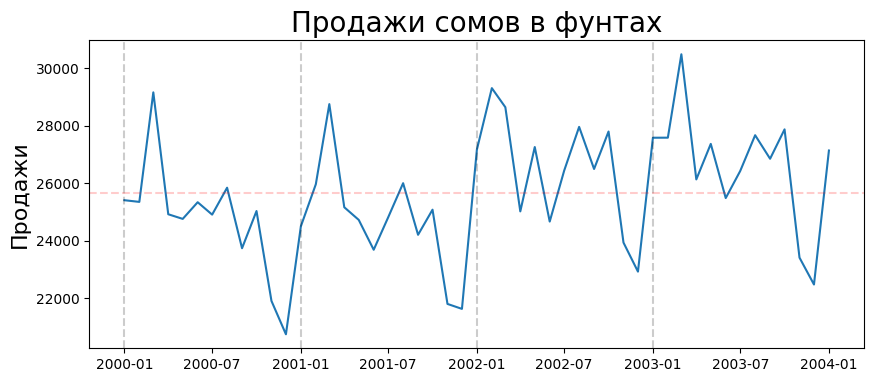

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Продажи сомов в фунтах', fontsize=20)
plt.ylabel('Продажи', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [ ]:
first_diff = lim_catfish_sales.diff()[1:]

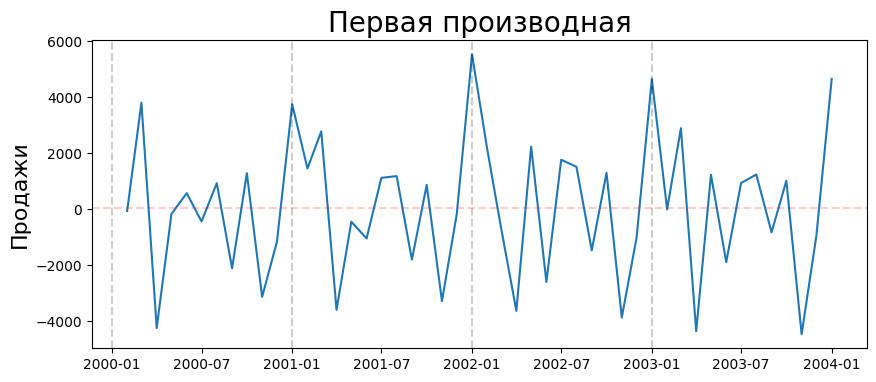

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Первая производная', fontsize=20)
plt.ylabel('Продажи', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

# ACF

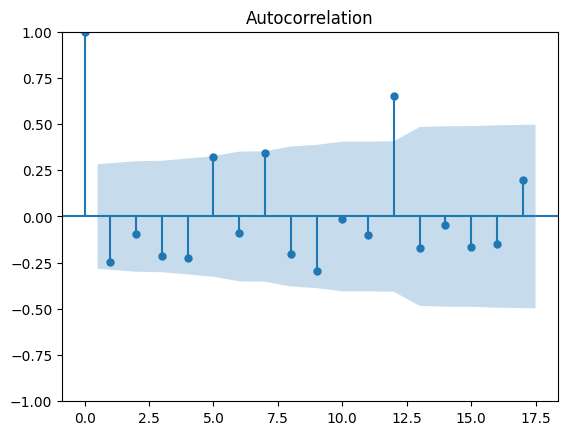

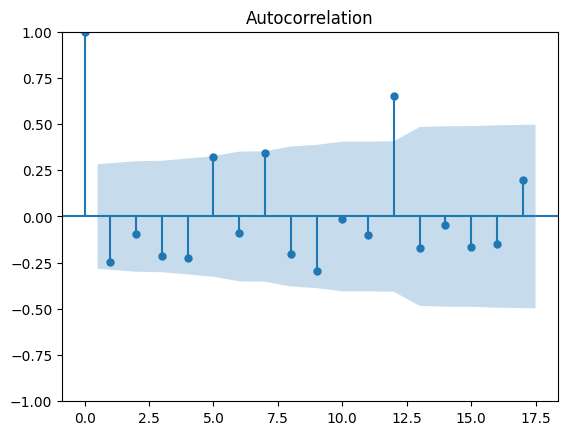

In [ ]:
sm.graphics.tsa.plot_acf(first_diff)

## Судя по графику, нам нужен лаг в 12 месяцев

# PACF

C:\Users\KudVl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


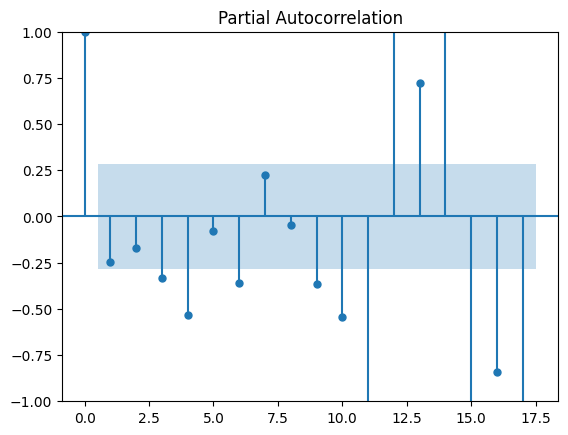

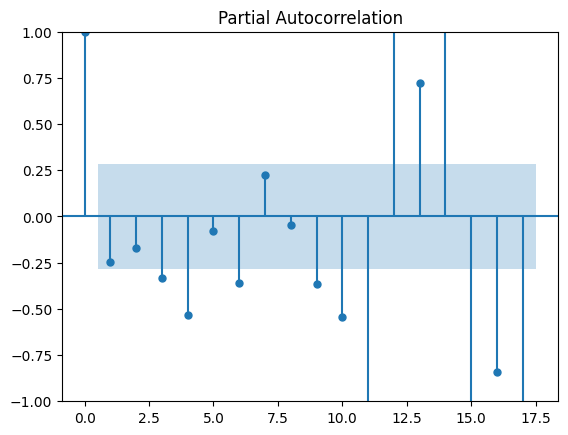

In [ ]:
sm.graphics.tsa.plot_pacf(first_diff)

## Для MA мы берем лаг в 4 шага

## Поделим датасет на train и test

In [ ]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# Обучаем модель 

In [ ]:
model = sm.tsa.arima.ARIMA(train_data, order=(12,0,4))
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

C:\Users\KudVl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\KudVl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model Fitting Time: 0.6172282695770264


C:\Users\KudVl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                ARIMA(12, 0, 4)   Log Likelihood                -357.573
Date:                Thu, 30 Mar 2023   AIC                            751.147
Time:                        18:41:06   BIC                            782.425
Sample:                    02-01-2000   HQIC                           762.612
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1791     96.453      0.251      0.802    -164.866     213.224
ar.L1         -0.1508      0.999     -0.151      0.880      -2.109       1.807
ar.L2          0.0333      0.563      0.059      0.9

## Делаем предсказание

In [ ]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

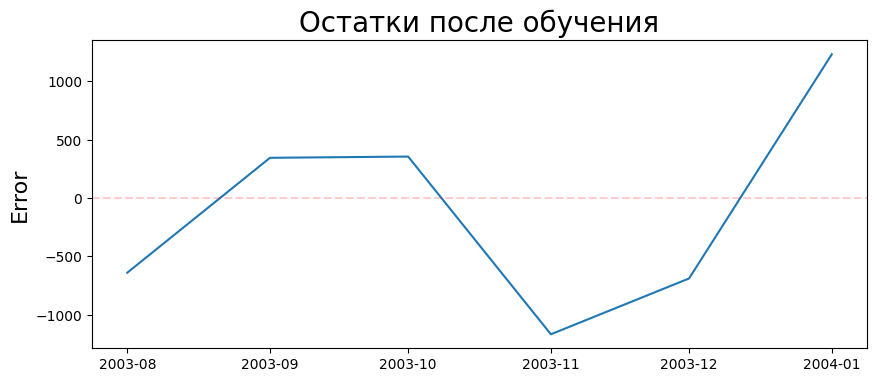

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Остатки после обучения', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

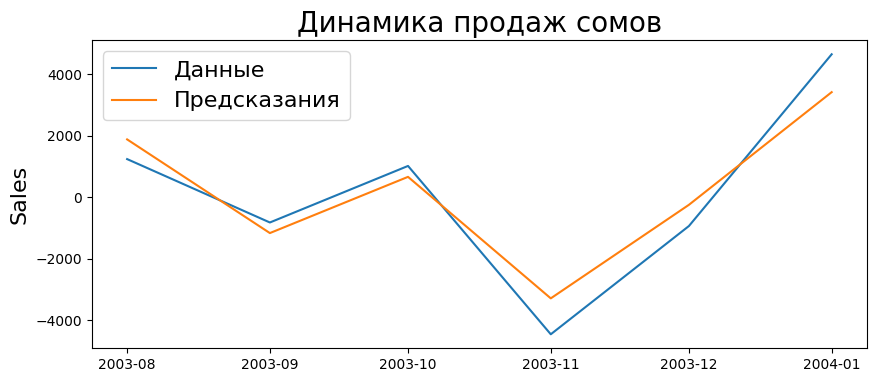

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Данные', 'Предсказания'), fontsize=16)

plt.title('Динамика продаж сомов', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [ ]:
print('Сумма квадратов ошибок:', np.sqrt(np.mean(residuals**2)))

Сумма квадратов ошибок: 818.6781678053895
